### Ленин жив, будем обучать модель ruGPT-3 говорить как Владимир Ильич
- Датасет всех диалогов из "Офиса" [тут](https://www.kaggle.com/datasets/nasirkhalid24/the-office-us-complete-dialoguetranscript)

##### План работ

1. Возьмем полное собрание сочинений Ленина В. И. в 55 томах
2. Составим датасет
3. Напишем код для LoRa адаптации модели
4. Проведем подбор гиперпараметров
5. Проведем обучение, запушим на HF для дальнешего использования в приложении

Ограничения:
Задача учебная, поэтому будем все делать просто, но надежно, логирование будем делать через wandb

In [ ]:
!pip install datasets transformers sentence-transformers huggingface_hub wandb peft -q

In [ ]:
!sudo apt-get install antiword

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  antiword
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 118 kB of archives.
After this operation, 603 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 antiword amd64 0.37-16 [118 kB]
Fetched 118 kB in 1s (158 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package antiword.
(Reading database ... 126209 files and directories currentl

In [ ]:
import pandas as pd
import os

import re

import shutil
import subprocess

import random
import numpy as np
import matplotlib.pyplot as plt
import wandb

from peft import get_peft_model, LoraConfig, TaskType, PeftModel

import random
from typing import Callable, Iterable
from huggingface_hub import login, create_repo, Repository, upload_folder, notebook_login

from datasets import Dataset
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, AutoModel

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers.optimization import get_linear_schedule_with_warmup
from google.colab import drive, userdata

from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets

from torch.utils.data import Dataset as torchDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import cosine_similarity

import glob

## Подготовка датасета

У нас есть некоторое количество документов, в которых содержиться текст.  

Задача: сделать готовый для обучения датасет, провести предварительную очистку текста, начальную нормализацию (регистр, спец-символы, разбить на чанки, провести токенизацию).  

Так же выведем основные метрики которые у нас получились.  

Не будем сохранять датасет, так как он учебный, но саму модель будем делать полностью совместимой с huggingface чтобы было можно легко ее згрузить и использовать уже в приложении.

In [ ]:
dataset_dir = '/content/drive/MyDrive/MIPT/Advanced_NLP_processing/hw2/Lenin'

In [ ]:
# Рекурсивно находим все файлы с расширением .doc
doc_files = glob.glob(os.path.join(dataset_dir, '**', '*.doc'), recursive=True)
print(f"Найдено трудов Ленина: {len(doc_files)}")

Найдено трудов Ленина: 50


In [ ]:
def clean_text(text):
    """
    Функция для очистки текста:
    - Убирает все символы, кроме букв (русских и латинских), цифр, пробелов и базовой пунктуации.
    """
    cleaned = re.sub(r'[^а-яА-ЯёЁa-zA-Z0-9\s.,!?;:]', '', text)
    return cleaned

In [ ]:
def extract_text_antiword(file_path):
    try:
        # Запускаем antiword для извлечения текста
        result = subprocess.run(['antiword', file_path],
                                stdout=subprocess.PIPE,
                                stderr=subprocess.PIPE)
        # Декодируем вывод в строку
        text = result.stdout.decode('utf-8', errors='ignore')
        return text
    except Exception as e:
        print(f"Ошибка при извлечении текста из {file_path}: {e}")
        return ""

# Извлекаем текст из всех файлов
all_texts = []
for file in doc_files:
    text = extract_text_antiword(file)
    if text:
        all_texts.append(text)

# Проверяем результат: выводим первые 500 символов первого файла
if all_texts:
    print("Пример извлечённого текста:")
    print(all_texts[0][:1000])
else:
    print("Текст не был извлечён ни из одного файла.")

Пример извлечённого текста:

Пролетарии всех стран, соединяйтесь

           ЛЕНИН

                                             ПОЛНОЕ
                                            СОБРАНИЕ
                                            СОЧИНЕНИЙ
                                           ПЕЧАТАЕТСЯ
                                        ПО ПОСТАНОВЛЕНИЮ
                                      ЦЕНТРАЛЬНОГО КОМИТЕТА
                                     КОММУНИСТИЧЕСКОЙ ПАРТИИ
                                        СОВЕТСКОГО СОЮЗА
   ИНСТИТУТ МАРКСИЗМА-ЛЕНИНИЗМА ПРИ ЦК КПСС

В. И. ЛЕНИН

      ПОЛНОЕ СОБРАНИЕ СОЧИНЕНИЙ

                                          ИЗДАНИЕ ПЯТОЕ

                                          ИЗДАТЕЛЬСТВО
                                     ПОЛИТИЧЕСКОЙ ЛИТЕРАТУРЫ
                                          МОСКВА« 1967
   ИНСТИТУТ МАРКСИЗМА-ЛЕНИНИЗМА ПРИ ЦК КПСС

В. И. ЛЕНИН

                                               ТОМ
                                        

In [ ]:
total_length = sum(len(text) for text in all_texts)
print(f"Длина всех текстов от Владимира Ильича: {total_length}")

Длина всех текстов от Владимира Ильича: 56132972


In [ ]:
len(all_texts)

49

In [ ]:
# итак у нас 56 миллионов букв от Владимира Ильича, модель должна хорошо обучиться пока мы собрали все в одни датафрейм, без разделения, следующшим этапом дальнейшая отчистка и разбивка на чанки
# для простоты сделаем маленький overlapping при разбивке на чанки, например 10% для того чтобы не сильно раздувать количество данных

In [ ]:
hf_token = userdata.get('huggy_write')
login(token=hf_token)

In [ ]:
notebook_login()

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: a-khalov (a-khalov-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Объединяем все тексты из списка в один большой текст
big_text = "\n".join(all_texts)

# Приводим текст к нижнему регистру
processed_text = big_text.lower()

# Очищаем текст:
# Оставляем только буквы (латиница и кириллица), цифры и базовую пунктуацию: . , ! ? ; :
processed_text = re.sub(r'[^a-zа-я0-9.,!?;:\s]', '', processed_text)

# Заменяем последовательности пробелов (включая переносы) на один пробел
processed_text = re.sub(r'\s+', ' ', processed_text).strip()

In [ ]:
total_length = sum(len(text) for text in processed_text)
print(f"Длина всех текстов от Владимира Ильича: {total_length}")

Длина всех текстов от Владимира Ильича: 50406488


In [ ]:
# наши данные готовы, теперь пришла пора построить модель

In [ ]:
# посмотрим сколько у нас слов в processed_text

words = processed_text.split()
num_words = len(words)
print("Общее количество слов:", num_words)

Общее количество слов: 7128743


In [ ]:
###############################
# 1. Загрузка модели и токенизатора
###############################

# русская GPT-3 на основе GPT-2 от Сбера)
model_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Если у токенизатора не задан токен паддинга, используем EOS токен
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

###############################
# 2. Подготовка датасета: объединение, очистка, разбиение на чанки с overlapping
###############################

# Параметры для разбиения на чанки
chunk_size = 512      # количество слов в чанке
overlap_ratio = 0.2    # 20% перекрытие
overlap_words = int(chunk_size * overlap_ratio)

# Разбиваем очищенный текст на список слов
words = processed_text.split()
num_words = len(words)
print("Общее количество слов:", num_words)

# Формируем чанки с перекрытием
chunks = []
start = 0
while start < num_words:
    end = start + chunk_size
    chunk_words = words[start:end]
    chunk_text = " ".join(chunk_words)
    chunks.append({'text': chunk_text})
    if end >= num_words:
        break
    start = end - overlap_words  # сдвигаемся с учетом перекрытия

# Преобразуем список чанков в датасет Huggingface
hf_dataset = Dataset.from_list(chunks)
print("Количество чанков:", len(hf_dataset))
print("Пример чанка:", hf_dataset[0])

###############################
# 3. Токенизация датасета и конвертация в формат Torch
###############################

def tokenize_function(example):
    # Токенизируем текст с обрезкой до максимальной длины (1024 токена)
    return tokenizer(example["text"], truncation=True, max_length=1024)

tokenized_dataset = hf_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_dataset.set_format("torch")


Общее количество слов: 7128743
Количество чанков: 17387
Пример чанка: {'text': 'пролетарии всех стран, соединяйтесь ленин полное собрание сочинений печатается по постановлению центрального комитета коммунистической партии советского союза институт марксизмаленинизма при цк кпсс в. и. ленин полное собрание сочинений издание пятое издательство политической литературы москва 1967 институт марксизмаленинизма при цк кпсс в. и. ленин том 5 май декабрь 1901 издательство политической литературы москва 1967 3k2 112 67 vii предисловие в пятый том полного собрания сочинений в. и. ленина входят произведения, написанные им в период с мая по декабрь 1901 года. обстановка этого периода в россии характеризовалась усилением революционного движения, направленного против царизма и всех остатков крепостничества, тормозивших экономическое и политическое развитие страны. разразившийся мировой экономический кризис охватил к этому времени и россию. ввиду особенности экономики россии, где быстрое развитие капи

Map:   0%|          | 0/17387 [00:00<?, ? examples/s]

In [ ]:
for name, module in model.named_modules():
    print(name)


transformer
transformer.wte
transformer.wpe
transformer.drop
transformer.h
transformer.h.0
transformer.h.0.ln_1
transformer.h.0.attn
transformer.h.0.attn.c_attn
transformer.h.0.attn.c_proj
transformer.h.0.attn.attn_dropout
transformer.h.0.attn.resid_dropout
transformer.h.0.ln_2
transformer.h.0.mlp
transformer.h.0.mlp.c_fc
transformer.h.0.mlp.c_proj
transformer.h.0.mlp.act
transformer.h.0.mlp.dropout
transformer.h.1
transformer.h.1.ln_1
transformer.h.1.attn
transformer.h.1.attn.c_attn
transformer.h.1.attn.c_proj
transformer.h.1.attn.attn_dropout
transformer.h.1.attn.resid_dropout
transformer.h.1.ln_2
transformer.h.1.mlp
transformer.h.1.mlp.c_fc
transformer.h.1.mlp.c_proj
transformer.h.1.mlp.act
transformer.h.1.mlp.dropout
transformer.h.2
transformer.h.2.ln_1
transformer.h.2.attn
transformer.h.2.attn.c_attn
transformer.h.2.attn.c_proj
transformer.h.2.attn.attn_dropout
transformer.h.2.attn.resid_dropout
transformer.h.2.ln_2
transformer.h.2.mlp
transformer.h.2.mlp.c_fc
transformer.h.2.mlp

In [ ]:
###############################
# 4. Подключение LoRA с использованием peft
###############################

# Настройка параметров LoRA
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # для задач генерации текста
    r=8,                         # размерность LoRA (rank)
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["c_attn", "c_proj"]  # предварительно посмотрели как называется в архитектуре
)

# Применяем LoRA к модели
model = get_peft_model(model, lora_config)
print("Модель с LoRA:")
print(model)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Модель с LoRA:
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): PeftModelForCausalLM(
          (base_model): LoraModel(
            (model): GPT2LMHeadModel(
              (transformer): GPT2Model(
                (wte): Embedding(50264, 768)
                (wpe): Embedding(2048, 768)
                (drop): Dropout(p=0.1, inplace=False)
                (h): ModuleList(
                  (0-11): 12 x GPT2Block(
                    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                    (attn): GPT2Attention(
                      (c_attn): lora.Linear(
                        (base_layer): Conv1D(nf=2304, nx=768)
                        (lora_dropout): ModuleDict(
                          (default): Dropout(p=0.1, inplace=False)
                        )
                        (lora_A): ModuleDict(
                          (default): Linear(in_features=768, out_features=8, 

In [ ]:
# поехали
# Инициализируем wandb (проект "lenin-GPT")

# так же будем пробовать инференс после каждого шага чтобы посмотреть на результаты работы модели


###############################
# 5. Настройка гиперпараметров и создание Trainer
###############################


def clean_output(text):
    # Убираем лишние пробелы и переводим любые повторяющиеся пробельные символы (включая \n, \t) в одиночный пробел
    text = re.sub(r"\s+", " ", text)
    # Обрезаем пробелы в начале и конце строки
    text = text.strip()
    return text



def grid_search_params(project_name, lr_list=[1e-5], bs_list=[8], epochs=10, push_to_hub=False, hf_username="Zamza" ):
    """
    Функция, которая перебирает заданные значения lr и batch_size,
    обучает модель и затем делает инференс для 3 тестовых запросов
    двумя способами (greedy и beam search).
    """
    prompts = [
        "Не тормози, сникерсни!",
        "Самое главное в жизни это",
        "Простой путь к богатству"
    ]

    for lr in lr_list:
        for bs in bs_list:
            run_name = f"lr_{lr}_bs_{bs}"

            hub_model_id = f"{hf_username}/lenin-GPT-{run_name}"

            # Настраиваем параметры тренировки
            training_args = TrainingArguments(
                output_dir="./results",
                num_train_epochs=epochs,  # тестовое обучение на 1 эпоху
                per_device_train_batch_size=bs,
                gradient_accumulation_steps=8,
                learning_rate=lr,
                logging_steps=50,
                save_steps=500,
                report_to="wandb",
                run_name=run_name,       # имя прогона в wandb
                fp16=True if torch.cuda.is_available() else False,
                push_to_hub=push_to_hub,            # Включаем пуш на HF, если задано
                hub_model_id=hub_model_id           # Название репозитория
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_dataset,
                data_collator=data_collator,
            )

            # Инициализируем wandb с именем, зависящим от гиперпараметров
            wandb.init(project=project_name, name=run_name, reinit=True)

            print(f"\n=== Начало обучения: {run_name} ===")
            print(f"learning_rate={lr}, batch_size={bs}")

            trainer.train()

            print(f"--- Завершено обучение: {run_name} ---\n")

            # После обучения делаем инференс по 3 запросам
            print("=== РЕЗУЛЬТАТЫ ИНФЕРЕНСА ===")
            for prompt in prompts:
                # Токенизируем запрос
                inputs = tokenizer(prompt, return_tensors="pt").to(trainer.model.device)

                # 1) Greedy
                greedy_ids = trainer.model.generate(
                    **inputs,
                    max_length=1024,
                    do_sample=False  # отключаем сэмплинг, чтобы был greedy
                )
                greedy_text = tokenizer.decode(greedy_ids[0], skip_special_tokens=True)
                greedy_text = clean_output(greedy_text)

                # 2) Beam Search
                beam_ids = trainer.model.generate(
                    **inputs,
                    max_length=1024,
                    num_beams=5,
                    early_stopping=True
                )
                beam_text = tokenizer.decode(beam_ids[0], skip_special_tokens=True)
                beam_text = clean_output(beam_text)

                # Выводим результаты
                print(f"ПРОМПТ: {prompt}")
                print(f"Greedy: {greedy_text}")
                print(f"Beam Search: {beam_text}")
                print("-" * 40)

            # Завершаем wandb run
            wandb.finish()

In [ ]:
# с текущими настройками лоры (выше)

grid_search_params(
    lr_list=[1e-5, 1e-4],
    bs_list=[4, 8]
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Начало обучения: lr_1e-05_bs_4 ===
learning_rate=1e-05, batch_size=4


Step,Training Loss
50,4.342700
100,4.193000
150,4.080200
200,4.030700
250,3.984000
300,3.967600
350,3.939700
400,3.922800
450,3.908600
500,3.904300


--- Завершено обучение: lr_1e-05_bs_4 ---

=== РЕЗУЛЬТАТЫ ИНФЕРЕНСА ===
ПРОМПТ: Не тормози, сникерсни!
Greedy: Не тормози, сникерсни!

— Не тормози, — сказал я. — Я не тормози.

— А я тормози, — сказал он. — Я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормози.

— А я тормоз

train/epoch,▁▂▂▃▄▅▅▆▇▇█
train/global_step,▁▂▂▃▄▅▅▆▇▇█
train/grad_norm,█▇▆▄▁▁▁▁▁▁
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▆▄▃▂▂▂▁▁▁
total_flos,8011148671033344.0
train/epoch,0.99931
train/global_step,543
train/grad_norm,0.46035
train/learning_rate,0.0
train/loss,3.9043


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Начало обучения: lr_1e-05_bs_8 ===
learning_rate=1e-05, batch_size=8


Step,Training Loss
50,3.951700
100,3.913600
150,3.897900
200,3.878700
250,3.867100


--- Завершено обучение: lr_1e-05_bs_8 ---

=== РЕЗУЛЬТАТЫ ИНФЕРЕНСА ===
ПРОМПТ: Не тормози, сникерсни!
Greedy: Не тормози, сникерсни!

— Сникерс, — сказал я, — я не могу понять, почему вы не можете понять, почему я не могу понять, почему вы не можете понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу понять, почему я не могу

train/epoch,▁▃▄▆▇█
train/global_step,▁▃▄▆▇█
train/grad_norm,█▂▄▁▂
train/learning_rate,█▆▄▃▁
train/loss,█▅▄▂▁
total_flos,8394755751124992.0
train/epoch,0.99724
train/global_step,271
train/grad_norm,0.40316
train/learning_rate,0.0
train/loss,3.8671


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Начало обучения: lr_0.0001_bs_4 ===
learning_rate=0.0001, batch_size=4


Step,Training Loss
50,3.802100
100,3.761600
150,3.708500
200,3.687600
250,3.659000
300,3.660000
350,3.640500
400,3.626800
450,3.618300
500,3.612400


--- Завершено обучение: lr_0.0001_bs_4 ---

=== РЕЗУЛЬТАТЫ ИНФЕРЕНСА ===
ПРОМПТ: Не тормози, сникерсни!
Greedy: Не тормози, сникерсни!

— А что, если я не соглашусь? — спросил я.

— Не соглашайся, — сказал он. — Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не согласен.

— Я не хочу, чтобы ты был в числе тех, кто не сог

train/epoch,▁▂▂▃▄▅▅▆▇▇█
train/global_step,▁▂▂▃▄▅▅▆▇▇█
train/grad_norm,▂█▃▃▂▃▅▃▃▁
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▇▅▄▃▃▂▂▁▁
total_flos,8011148671033344.0
train/epoch,0.99931
train/global_step,543
train/grad_norm,0.40342
train/learning_rate,1e-05
train/loss,3.6124


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Начало обучения: lr_0.0001_bs_8 ===
learning_rate=0.0001, batch_size=8


Step,Training Loss
50,3.627200
100,3.596900
150,3.584800
200,3.573800
250,3.562900


--- Завершено обучение: lr_0.0001_bs_8 ---

=== РЕЗУЛЬТАТЫ ИНФЕРЕНСА ===
ПРОМПТ: Не тормози, сникерсни!
Greedy: Не тормози, сникерсни!



































































































































































































































































































































































































































































































































































































































































































































































































































































































train/epoch,▁▃▄▆▇█
train/global_step,▁▃▄▆▇█
train/grad_norm,█▄▅▅▁
train/learning_rate,█▆▄▃▁
train/loss,█▅▃▂▁
total_flos,8394755751124992.0
train/epoch,0.99724
train/global_step,271
train/grad_norm,0.30614
train/learning_rate,1e-05
train/loss,3.5629


### Количество итераций в логах

Шаги считаются только при обновлении весов, а микробачи, которые накапливают градиенты в течении 8 шагов (как у нас) не учитываются, поэтому при баче в 4 и количестве объектов 17 000 у нас всего 543 итерации

Найдено запусков: 5
Run: vibrant-planet-1 State: finished
Config: {'bf16': False, 'fp16': True, 'fsdp': [], 'seed': 42, 'tf32': None, 'debug': [], 'n_ctx': 2048, 'optim': 'adamw_torch', 'top_k': 50, 'top_p': 1, 'n_embd': 768, 'n_head': 12, 'prefix': None, 'do_eval': False, 'n_inner': None, 'n_layer': 12, 'no_cuda': False, 'use_cpu': False, 'do_train': False, 'id2label': {'0': 'LABEL_0'}, 'label2id': {'LABEL_0': 0}, 'run_name': 'lenin-GPT-tets', 'use_ipex': False, 'adafactor': False, 'data_seed': None, 'deepspeed': None, 'do_sample': False, 'hub_token': '<HUB_TOKEN>', 'log_level': 'passive', 'max_steps': -1, 'num_beams': 1, 'ray_scope': 'last', 'report_to': ['wandb'], 'typical_p': 1, 'use_cache': True, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'attn_pdrop': 0.1, 'do_predict': False, 'embd_pdrop': 0.1, 'eval_delay': 0, 'eval_steps': None, 'is_decoder': False, 'local_rank': 0, 'max_length': 20, 'min_length': 0, 'model_type': 'gpt2', 'optim_args': None, 'output_dir': './results', 'past_index

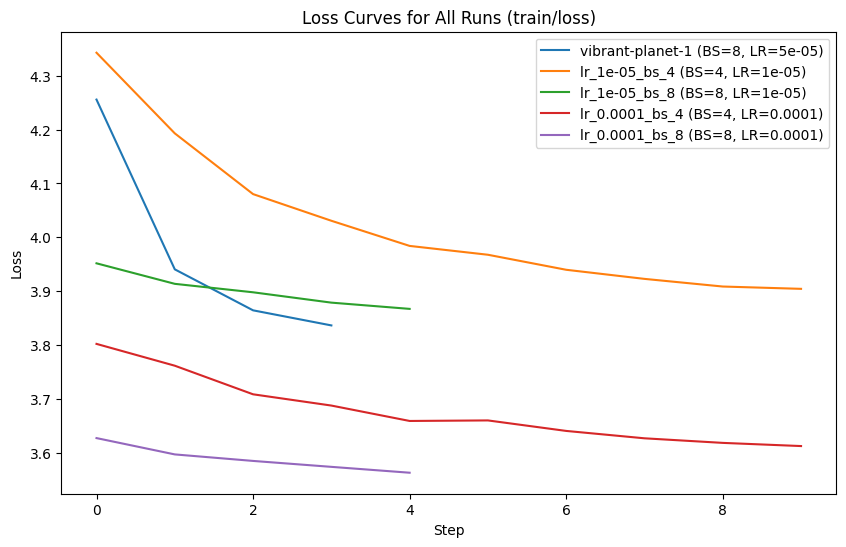


=== ЛУЧШИЙ ЗАПУСК ПО МИНИМАЛЬНОМУ ЛОССУ ===
Имя запуска: lr_0.0001_bs_8 (BS=8, LR=0.0001)
Минимальный loss: 3.5629
Гиперпараметры (config): {'bf16': False, 'fp16': True, 'fsdp': [], 'seed': 42, 'tf32': None, 'debug': [], 'n_ctx': 2048, 'optim': 'adamw_torch', 'top_k': 50, 'top_p': 1, 'n_embd': 768, 'n_head': 12, 'prefix': None, 'do_eval': False, 'n_inner': None, 'n_layer': 12, 'no_cuda': False, 'use_cpu': False, 'do_train': False, 'id2label': {'0': 'LABEL_0'}, 'label2id': {'LABEL_0': 0}, 'run_name': 'lr_0.0001_bs_8', 'use_ipex': False, 'adafactor': False, 'data_seed': None, 'deepspeed': None, 'do_sample': False, 'hub_token': '<HUB_TOKEN>', 'log_level': 'passive', 'max_steps': -1, 'num_beams': 1, 'ray_scope': 'last', 'report_to': ['wandb'], 'typical_p': 1, 'use_cache': True, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'attn_pdrop': 0.1, 'do_predict': False, 'embd_pdrop': 0.1, 'eval_delay': 0, 'eval_steps': None, 'is_decoder': False, 'local_rank': 0, 'max_length': 20, 'min_length': 0, 'mode

In [ ]:
# построим график лоса тут, но данные будем брать с wandb

# Инициализируем API
api = wandb.Api()
entity = "a-khalov-"
project_name = "lenin-GPT"

runs = api.runs(f"{entity}/{project_name}")
print("Найдено запусков:", len(runs))

all_labels = []
all_loss_series = []
all_configs = []  # чтобы сохранить конфиги всех запусков

for run in runs:
    print("Run:", run.name, "State:", run.state)
    if run.state != "finished":
        continue

    # Забираем конфиг (где могут храниться гиперпараметры)
    config = run.config
    print("Config:", config)

    batch_size = config.get("per_device_train_batch_size", "N/A")
    lr = config.get("learning_rate", "N/A")

    # Используем scan_history для получения всех логов по ключу "train/loss"
    history_gen = run.scan_history(keys=["train/loss"])
    history_list = list(history_gen)

    if not history_list:
        print(f"История пустая для {run.name}")
        continue

    # Извлекаем значения из поля "train/loss"
    loss_values = [entry["train/loss"] for entry in history_list if "train/loss" in entry]
    if not loss_values:
        print(f"Нет значений 'train/loss' для {run.name}")
        continue

    # Сформируем подпись для легенды с учётом гиперпараметров
    label = f"{run.name} (BS={batch_size}, LR={lr})"

    # Сохраняем серию лосса и подпись
    all_labels.append(label)
    all_loss_series.append(loss_values)
    all_configs.append(config)

# Если вообще нашлись данные по лоссу
if not all_loss_series:
    print("Нет данных по лоссу ни у одного завершённого запуска.")
else:
    # Строим все кривые на одном графике
    plt.figure(figsize=(10, 6))

    for label, loss_values in zip(all_labels, all_loss_series):
        plt.plot(loss_values, label=label)

    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Loss Curves for All Runs (train/loss)")
    plt.legend()
    plt.show()

    # Определяем, у какого запуска минимальный лосс (берём минимум по всей кривой)
    min_loss = float("inf")
    best_run_index = -1

    for i, loss_values in enumerate(all_loss_series):
        current_min = min(loss_values)
        if current_min < min_loss:
            min_loss = current_min
            best_run_index = i

    if best_run_index >= 0:
        print("\n=== ЛУЧШИЙ ЗАПУСК ПО МИНИМАЛЬНОМУ ЛОССУ ===")
        print(f"Имя запуска: {all_labels[best_run_index]}")
        print(f"Минимальный loss: {min_loss}")
        print(f"Гиперпараметры (config): {all_configs[best_run_index]}")
    else:
        print("Не удалось найти лучший запуск, возможно, нет валидных данных по лоссу.")

In [ ]:
# финальное обучение модели на 10 эпохах
grid_search_params(
    project_name="lenin-GPT",
    lr_list=[1e-4],
    bs_list=[8],
    epochs=10,
    push_to_hub=True
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



=== Начало обучения: lr_0.0001_bs_8 ===
learning_rate=0.0001, batch_size=8


Step,Training Loss
50,3.530100
100,3.508500
150,3.500100
200,3.490600
250,3.478700
300,3.544700
350,3.475500
400,3.458400
450,3.447500
500,3.475300


--- Завершено обучение: lr_0.0001_bs_8 ---

=== РЕЗУЛЬТАТЫ ИНФЕРЕНСА ===
ПРОМПТ: Не тормози, сникерсни!
Greedy: Не тормози, сникерсни!
Beam Search: Не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! не тормози, сникерсни! н

train/epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train/grad_norm,▆▂▄▂▂▆█▄▃▄▂▄▃▇▄▃▃▃▂▂▁▂▃▄▃▂▃▃▁▇▅▄▃▅▂▄█▄▄▄
train/learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▇▇▆▆▆▅▅▆▅▄▃▄▆▄▃▃▃▂▃▂▂▃▂▅▂▂▂▅▃▁▁▄▁▁▃▂▁▁▁
total_flos,8.410831291507507e+16
train/epoch,9.99724
train/global_step,2710
train/grad_norm,0.35377
train/learning_rate,0.0
train/loss,3.3721


## Выводы

1. На бОльшем объеме бача модель учится лучше, даже на 8 показывает заметно более низкие результаты по функции потерь;
2. LR слеудет увеличить и сделать его аггресивнее, в целом лосс-кривая показывает стабильное ровное обучение;
3. Тестовый инференс показывает много мусора, особенно пробелы и переносы
4. Модель (видимо из за своего небольшого размера) склонна к зацикливанию, но оно лечится простой фильтрацией, которую я добавлю в приложение;
5. В целом библиотека transformers и Huggingface делают работу очень комфортной и понятной.

P.S. BEAM search конечно показывает лучше результаты. На 1 эпохе стилизация под домен не заметна, посмотрим что будет на 10, код инференса представлен ниже.

P.S.S. инференс медленный, даже на A100

## Инференс

In [ ]:
# напишем код инференса по пользовательскому инпуту

# 1) Загрузка модели и токенизатора


base_model_name = "ai-forever/rugpt3small_based_on_gpt2"
peft_model_id = "Zamza/lenin-GPT-lr_0.0001_bs_8"


# на гитхаб пушится не сама модель, она остается неизменной а только PEFT

tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModelForCausalLM.from_pretrained(base_model_name)
model_inf = PeftModel.from_pretrained(base_model, peft_model_id)


def generate_responses(prompt: str, max_len=256, temperature=0.3):
    """
    Генерирует два варианта ответа:
    1) Greedy (без сэмплинга).
    2) Сэмплинг с заданной температурой.
    """
    # Токенизируем и переносим на устройство модели
    inputs = tokenizer(prompt, return_tensors="pt").to(model_inf.device)

    # Greedy
    output_ids_greedy = model_inf.generate(
        **inputs,
        max_length=max_len,
        do_sample=False  # чисто жадная генерация
    )
    greedy_text = tokenizer.decode(output_ids_greedy[0], skip_special_tokens=True)

    greedy_text = clean_output(greedy_text)

    # Sampling
    # - do_sample=True
    # - температура (temperature)
    # - можно также добавить top_k, top_p для управления разнообразием
    output_ids_sample = model_inf.generate(
        **inputs,
        max_length=max_len,
        do_sample=True,
        temperature=temperature,
        top_k=50,
        top_p=0.95
    )
    sample_text = tokenizer.decode(output_ids_sample[0], skip_special_tokens=True)
    sample_text = clean_output(sample_text)

    return greedy_text, sample_text

# 5) Бесконечный цикл опроса пользователя
while True:
    user_input = input("Введите ваш запрос (или 'exit' для выхода): ")
    if user_input.lower().strip() == "exit":
        print("Завершение работы.")
        break

    # Генерируем две версии ответа
    greedy_answer, sample_answer = generate_responses(
        prompt=user_input,
        max_len=512,
        temperature=0.8
    )

    print("\n=== РЕЗУЛЬТАТ ГЕНЕРАЦИИ ===")
    print("------ Greedy ------")
    print(greedy_answer)
    print("------ Сэмплинг (temperature=0.3) ------")
    print(sample_answer)
    print("========================================\n")

Введите ваш запрос (или 'exit' для выхода): Что такое коммунизм?

=== РЕЗУЛЬТАТ ГЕНЕРАЦИИ ===
------ Greedy ------
Что такое коммунизм?
------ Сэмплинг (temperature=0.3) ------
Что такое коммунизм? По-русски коммунизм это такая демократия. 33207925 fedor-ermakov 2018-12-11 01:14:00 Футбол на Урале - Чемпионат России по футболу 2018 Футбол на Урале - Чемпионат России по футболу 2018 33207926 fedor-ermakov 2018-12-10 23:07:00 Минус для страны с "счастьем в кармане" 33207927 fedor-ermakov 2018-12-10 18:56:00 «Мы не хотим жить в России, мы хотим жить в Казахстане» 33207928 fedor-ermakov 2018-12-09 23:55:00 Минус для страны с «счастьем в кармане» 33207929 fedor-ermakov 2018-12-10 18:24:00 «Минус для страны с «счастьем в кармане»» 33207930 fedor-ermakov 2018-12-09 20:45:00 Санкции против РФ могут выйти за пределы России 33207931 fedor-ermakov 2018-12-09 19:33:00 Венесуэла не может вернуть Украине Крым 33207932 fedor-ermakov 2018-12-09 17:25:00 Узник сталинских лагерей "Архипелаг ГУЛАГ" 33207

Вывод: при уменьшении темпертауры ответы становятся живее и вариантивнее.   

Качество ответов оставляет желать лучшего даже после 10 эпох обучения